In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(203)
import numpy as np
np.random.seed(345)
from rich import print

In [13]:
from pathlib import Path

## Running a Multi-deal negotiation

ANL 2025's challenge is to develop agents capable of negotiating sequentially a set of interrelated deals (Multi-deal negotiation). You can create and run a multi-deal negotiation using special tools provided by the anl2025 package. (2)

### A random multideal-session

In [14]:
from anl2025 import make_multideal_scenario

scenario = make_multideal_scenario(nedges=8)

**What just happened?**

We created a random multi-deal session with one center agent and 8 edge agents. The center agent negotiates with all the edge agents. Each one of these negotiations is called a **negotiation thread** and the whole set is called a **multi-deal negotiation**.

The following figure shows the structure of a typical such scenario (with 8 edge agents). Each one of the **edge agents** has its own utility function $e_i$.

The **center agent** faces a different challenge. It has one utility function defined for each **negotiation thread** called a **side utility function** ($s_i$). The overall utility of the center agent is some function (called the **combination function**) of the side utilities it gets in all the negotiation threads.

```{note}
In ANL 2025, the center agent negotiates with the side agents sequentially. It completes a negotiation with one edge agent before starting the next negotiation with the next edge agent. At no time does the center agent have multiple negotiation threads running at the same time.
```

The following figure shows the situation:

![Example](Slide2.jpeg)

The function `make_multideal_scenario` creates such a scenario. The combination function used by default is `max` (i.e. the center get the maximum utlility it gets in all negotiations) but you can easily change it. See the full documentation of `make_multideal_scenario` in the Reference for more details of how to control all aspects of scenario  generation.


The function `run_session` runs one multi-deal negotiation. Behind the scenes, a lot of things happen in this small function. The function `run_session` automatically outputs logs of each thread, specifying what bid happened at what round. Moreover, it outputs a graph of the utilities of the center agent and the edge agents. By default, you can find this folder here **...\negmas\anl2025\session**.

Below, we show the outputted graphs. On the left, one can see the bids that were posed, with the utility of the center agent on the y-axis and the utility of the edge agent on the x-axis. The right figures show the bids over time, one for both agents.



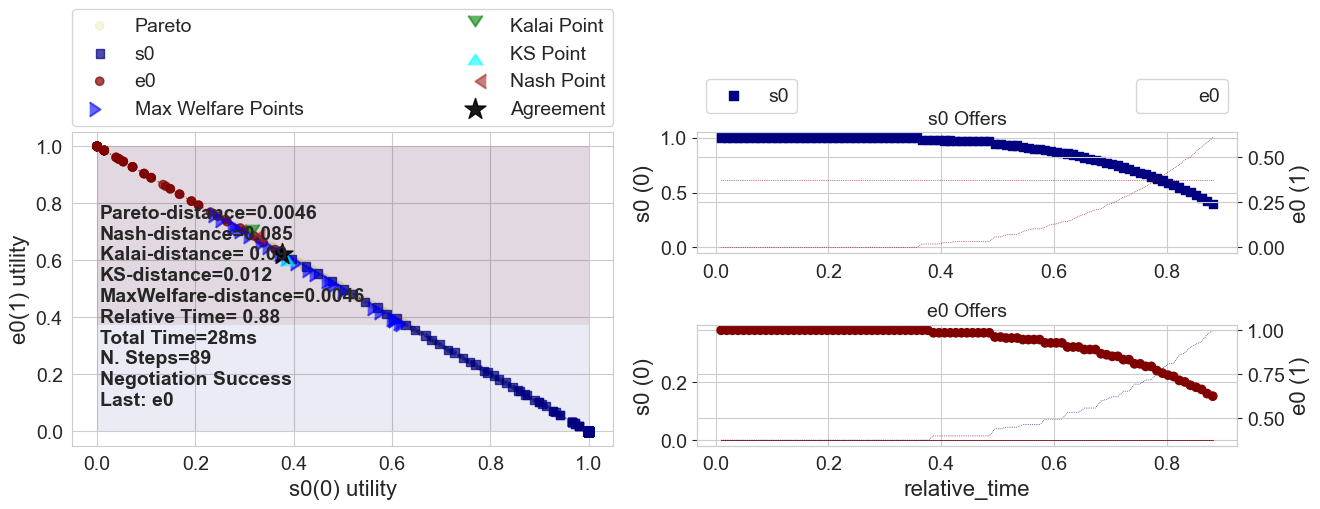

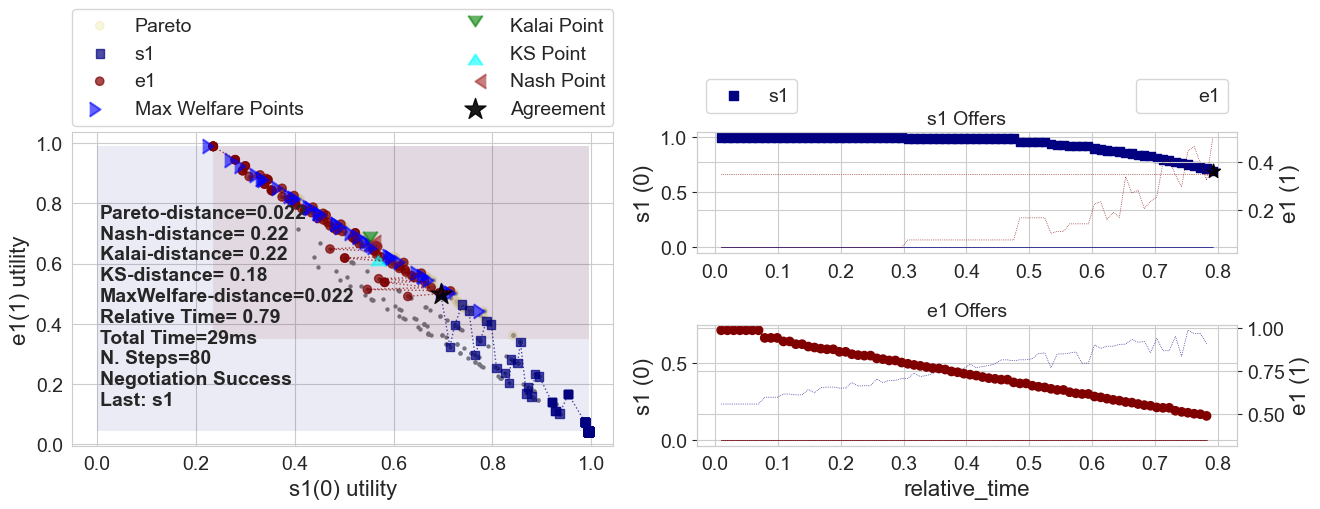

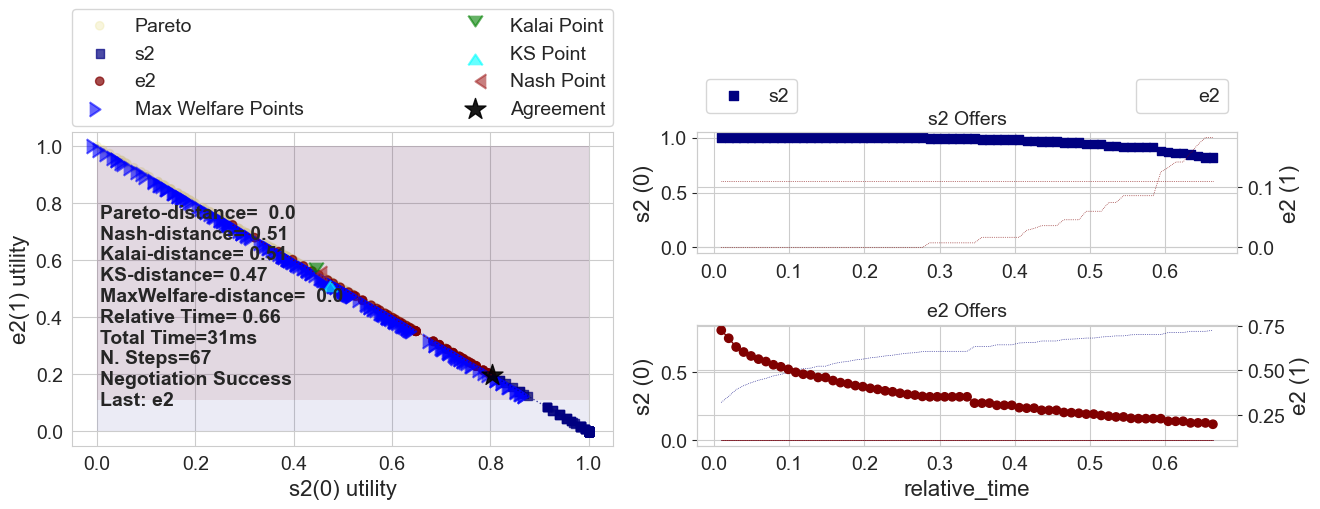

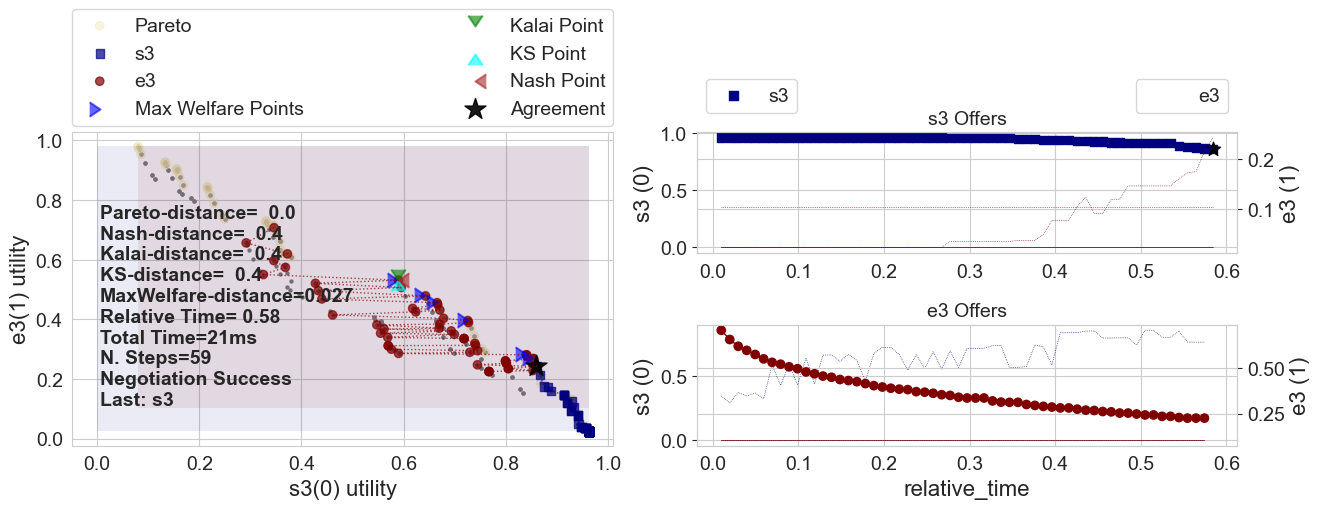

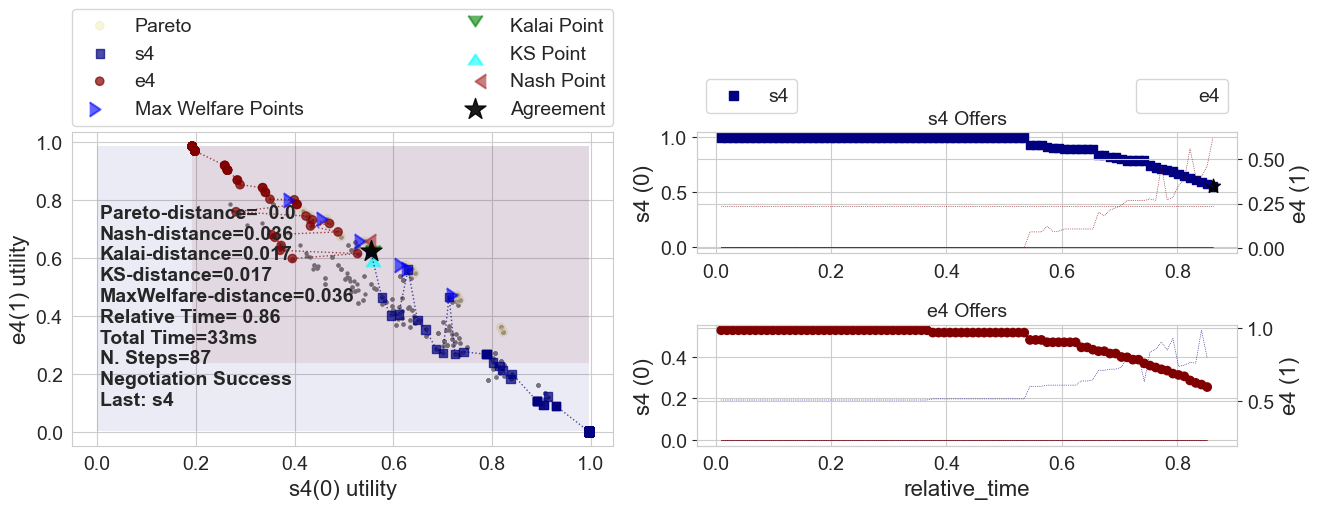

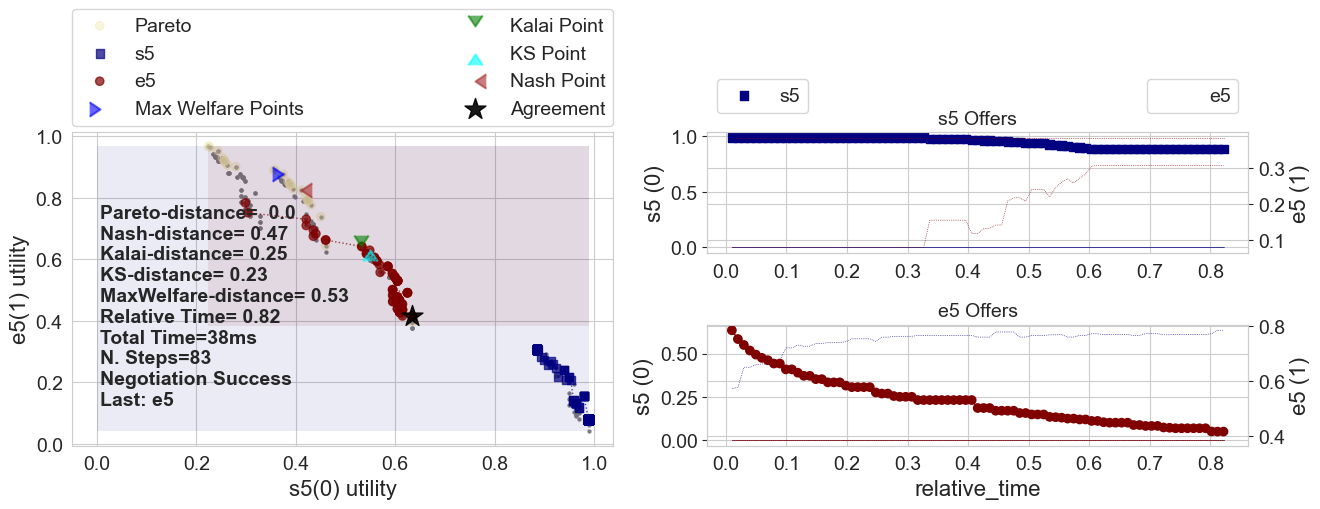

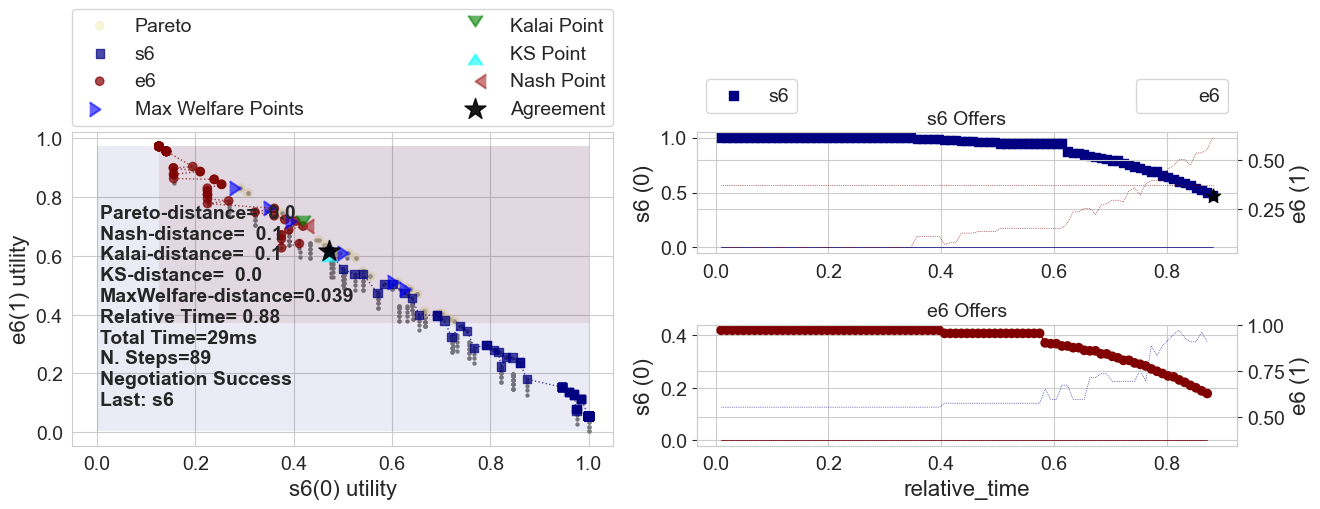

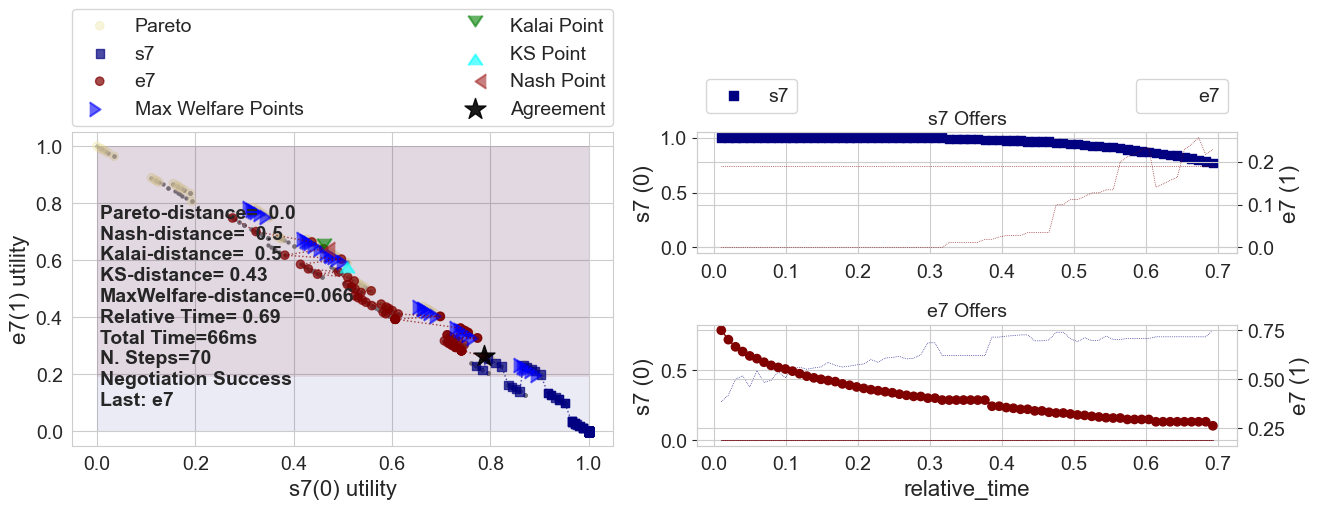

In [15]:
from anl2025 import run_session
results = run_session(scenario)


Like mentioned, a lot of things happen behind the scenes, with all default parameters. The default parameters are all in line with the criteria of ANL2025, so you can use this function to find your way in the competition. For example, look at the parameters that you can change yourself, such as the center agent, edge agents and maximum number of rounds (`nsteps`):

In [16]:


centeragent = "Random2025"
edgeagents = [
        "Random2025",
         "Linear2025",
        "Conceder2025"]
if False: #this function will not run, remove this line if you want it to run.
        results = run_session(
                scenario=scenario,
                center_type=centeragent,
                edge_types=edgeagents,
                nsteps=10)

You can also ask for specific types of output, by looking into `results`, e.g.:

In [17]:

print(f"Center utility: {results.center_utility}")
print(f"Edge Utilities: {results.edge_utilities}")

Center utility: 0.8597682225581035

Edge Utilities: [0.6231814702215154, 0.5004659393834174, 0.19763095600241815, 0.2420100529169169, 
0.6239709131183655, 0.41525772055401966, 0.61641875459796, 0.26278285441816085]

### A dinners' scheduling session

In the previous example, the center utility function was defined in terms of individual side utility functions (one per negotiation threads). A more general case is when the center utility function is defined directly in terms of the outcomes of negotiation threads without locally defined utility functions. The following figure shows an example of this kind of scenario:

![Global Utility Function Example](Slide1.jpeg)

The `anl2025` package allows you to create such scenarios using the `LambdaCenterUFun` class (See Reference). One class of these scenarios is the **Dinners** scenarios in which one person (center agent) is negotiating with her friends (edge agents) about the day to go out for dinner. Each friend has her own utility function for different days. The center agent has a utility for each combination of agreements (i.e. she may prefer to go out once every night except in Tuesdays,

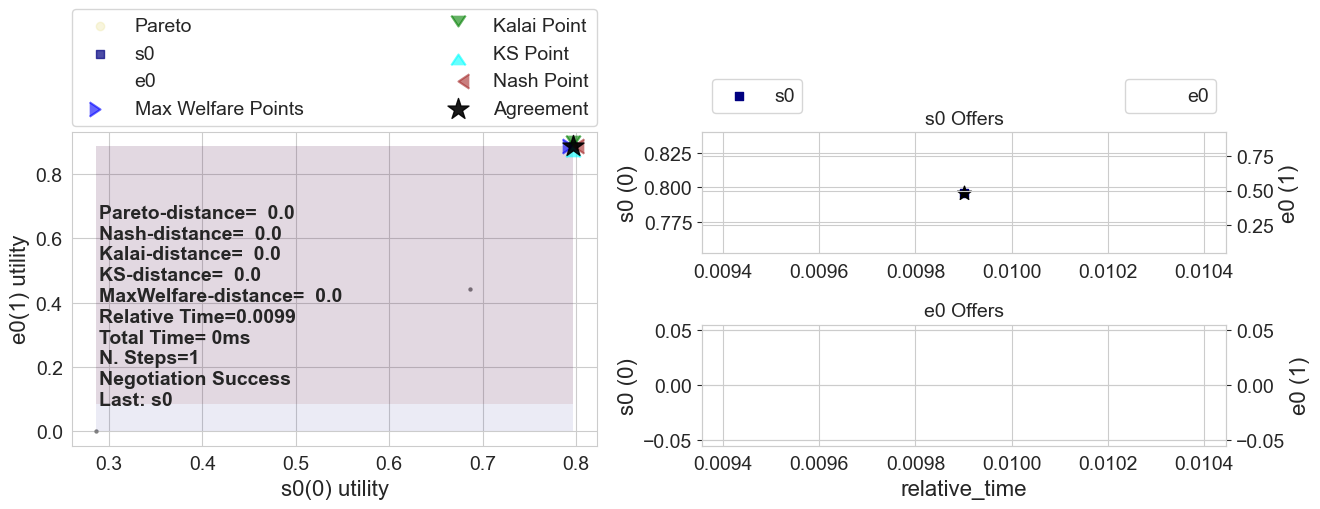

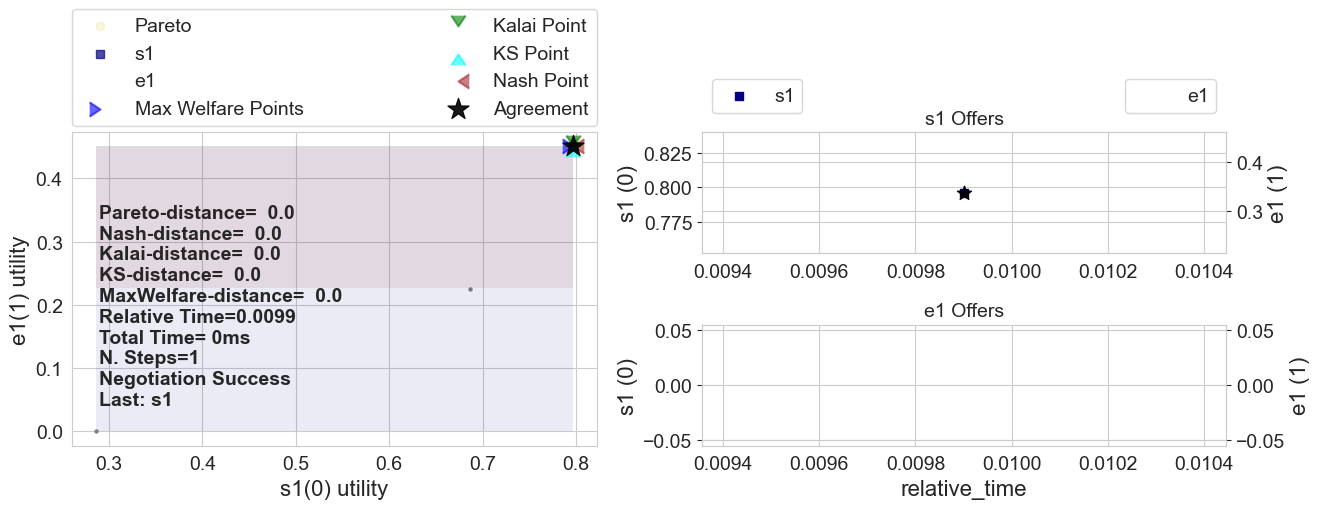

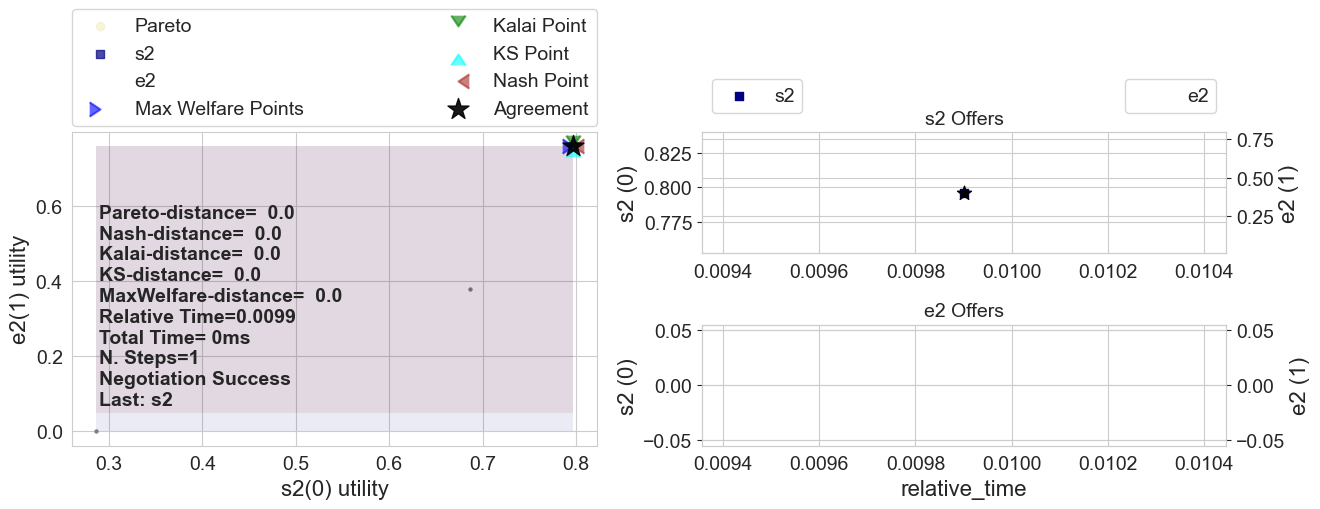

In [18]:
from anl2025 import make_dinners_scenario

results = run_session(make_dinners_scenario())